#### Step 1. Problem Understanding
1. Problem Understanding: Loan Repayment Prediction
* Mission Brief: Numida wants to predict the performance of 2,000 loans under due diligence. The ultimate goal? Help Loan Officers make smarter decisions and set interest rates that align with risk. 
* Game Plan: To predict whether these new loans will be repaid on time or  late. 
* Target Variable: Will the loan be repaid within 15 days?
    * 1 = Loan repaid on time (woohoo! 🏆).
    * 0 = Loan repaid more than 15 days late (ouch! 😬)

 `Loan Data Set`

 | Column Name          	| Description                                                                                                                                                          |
 |--------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
 | loan_id              	|	                                                                                                                                                                  |
 | business_id          	|                                                                                                                                                                      |
 | credit_officer_id     	| Identifier for the Numida member of staff responsible for approving (and collecting on) the loan                      	                                            |
 | acquisition_channel  	| The channel through which the customer first came to Numida                                                                                                           |
 | sector 	              | The type of business the customer has - Clinic, or Beauty & Fashion for instance                                                                                      |
 | principal            	| If the loan was approved, this is the amount (in UGX) that was disbursed. If the loan wasn't approved, this is the amount that the CRO evaluated.                 	|
 | total_owing_at_issue 	| The amount of money the customer was required to pay back when the loan was disbursed. It includes the principal, fees, and interest but does NOT include any penalties. |
 | application_number   	| Running count of how many times the customer has submitted a loan application.                                                                                        |
 | applying_for_loan_number | The `loan_number` that the customer is applying for. There can be many loans for the same customer with the same value since a customer can be declined, and re-apply. |
 | employee_count       	| The customer-reported number of employees working for the customer.                                                                                                   |
 | **The following are only available after the loan has been approved (or declined). The information is missing, null or in an intermediary step before then.**                                     |
 | loan_number          	| Running count of how many loans the customer has taken up to and including the current loan. Null if the loan has not been approved.                                   |
 | approval_status      	| Status used to determine whether or not a loan was disbursed. If not, it provides the reason.                                                                         |
 | dismissal_description    | The reason for the loan being declined or cancelled.                                                                                                                 |
 | payment_status       	| The status of the loan (Current: loan is outstanding and before due date, Arrears: outstanding after the due date).                                                   |
 | paid_late            	| Boolean indicating if the loan was paid back late. If true, the loan was paid back late.                        	                                                  |
 | total_recovered_on_time  | Sum of all payments made before the due date. NULL until the due date has passed.                                                                                      |
 | total_recovered_15_dpd   | Sum of all payments made within 15 days after the due date. NULL until 15 days after the due date.                                                                    |
 | cash_yield_15_dpd    	| Sum of all payments received from the customer by 15 days past the due date, less the principal disbursed. A measure of the gross profit or loss from the loan.    	|

`Payment Data`

 | Column Name   	| Description                                                                                         |
 |-------------------|-----------------------------------------------------------------------------------------------------|
 | loan_id       	|                                                                                                     |
 | paid_at       	| Timestamp of when the payment was made.                                                             |
 | amount        	| Value of the payment.                                                                               |
 | transaction_type  | `Deposit` for a customer payment, `Discount` for a bonus or other discount provided by Numida. Both count equally towards paying off a loan. |

#### Step 2. Data Loading and Exploration (EDA)
Step 2.1 Loading the data – Let’s Begin the Adventure!

In [52]:
# Importing the necessary Libraries
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [17]:
def load_data(loan_train_path: str, payment_train_path: str, test_loan_path: str):
    """
    Loads the loan training data, payment training data, and test data.
    
    Args:
    loan_train_path (str): Path to the loan training data file.
    payment_train_path (str): Path to the payment training data file.
    test_loan_path (str): Path to the test loan data file.

    """
    loan_train = pd.read_csv(loan_train_path)
    payment_train = pd.read_csv(payment_train_path)
    test_loan = pd.read_csv(test_loan_path)
    
    return loan_train, payment_train, test_loan

loan_train, payment_train, test_loan = load_data( os.path.join('..', 'data', 'raw', 'train_loan_data.csv'),os.path.join('..', 'data', 'raw', 'train_payment_data.csv'),os.path.join('..', 'data', 'raw', 'test_loan_data.csv'))

In [18]:
# Display the shape of the datasets
print("Loan train data Shape:", loan_train.shape)
print("Payment train data Shape:", payment_train.shape)
print("Test loan data Shape:", test_loan.shape)

Loan train data Shape: (25102, 17)
Payment train data Shape: (83275, 4)
Test loan data Shape: (2000, 18)


In [19]:
# glimpse of the loan_train first rows
loan_train.head()

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
0,860706,604923,131449.0,NaN,Friend,Beauty Fashion,300000.0,345500.0,1,1,1.0,1.0,Approved,False,345500.0,345500.0,45500.0
1,975605,604923,131449.0,NaN,Friend,Beauty Fashion,330000.0,380000.0,2,2,2.0,1.0,Approved,False,380000.0,380000.0,50000.0
2,126416,122438,NaN,Client does not have all of the requirements,Friend,Food Staple Goods,300000.0,NaN,1,1,NaN,1.0,Declined,False,NaN,NaN,NaN
3,127617,122438,108019.0,NaN,Friend,Food Staple Goods,200000.0,221100.0,2,1,1.0,1.0,Approved,False,221100.0,221100.0,21100.0
4,148416,122438,108019.0,NaN,Friend,Food Staple Goods,220000.0,243200.0,3,2,2.0,1.0,Approved,False,243200.0,243200.0,23200.0


In [20]:
# glimpse of the payment_train first rows
payment_train.head()

,loan_id,paid_at,amount,transaction_type
0,834148,2023-11-25 17:44,200000.0,Deposit
1,4028,2019-02-09 16:55,1036300.0,NaN
2,4798,2019-04-25 15:50,1228500.0,NaN
3,2082,2018-08-22 10:41,50000.0,NaN
4,3802,2019-01-05 16:00,1384600.0,NaN


In [21]:
# having a look at the columns of the datasets
print(loan_train.columns)
print(payment_train.columns)

Index(['loan_id', 'business_id', 'credit_officer_id', 'dismissal_description',
       'acquisition_channel', 'sector', 'principal', 'total_owing_at_issue',
       'application_number', 'applying_for_loan_number', 'loan_number',
       'employee_count', 'approval_status', 'paid_late',
       'total_recovered_on_time', 'total_recovered_15_dpd',
       'cash_yield_15_dpd'],
      dtype='object')
Index(['loan_id', 'paid_at', 'amount', 'transaction_type'], dtype='object')


In [22]:
test_loan.head()

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,payment_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
0,1003730,604923,131449,NaN,Friend,Beauty Fashion,350000.0,399500.0,3,3,3,1.0,Approved,Paid up,False,399500.0,399500.0,49500.0
1,986527,122438,279289,NaN,Friend,Food Staple Goods,1500000.0,1771000.0,30,27,27,1.0,Approved,Paid up,False,1771000.0,1771000.0,271000.0
2,985254,675619,279290,NaN,Sales Team,Metal and Woodworking,578400.0,648400.0,2,2,2,NaN,Approved,Paid up,False,648400.0,648400.0,70000.0
3,989887,312482,108022,NaN,Friend,Mobile Money Airtime,650000.0,768300.0,20,19,19,1.0,Approved,Written off,True,0.0,0.0,-650000.0
4,994582,654630,137987,NaN,Friend,Hospitality,594000.0,665900.0,3,3,3,NaN,Approved,Paid up,False,665900.0,665900.0,71900.0


Further Information about the data.

In [23]:
print(loan_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25102 entries, 0 to 25101
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   25102 non-null  int64  
 1   business_id               25102 non-null  int64  
 2   credit_officer_id         24630 non-null  float64
 3   dismissal_description     554 non-null    object 
 4   acquisition_channel       25102 non-null  object 
 5   sector                    25102 non-null  object 
 6   principal                 25102 non-null  float64
 7   total_owing_at_issue      23938 non-null  float64
 8   application_number        25102 non-null  int64  
 9   applying_for_loan_number  25102 non-null  int64  
 10  loan_number               23938 non-null  float64
 11  employee_count            24246 non-null  float64
 12  approval_status           25102 non-null  object 
 13  paid_late                 25102 non-null  bool   
 14  total_

In [24]:
print(payment_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83275 entries, 0 to 83274
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_id           83275 non-null  int64  
 1   paid_at           83275 non-null  object 
 2   amount            83275 non-null  float64
 3   transaction_type  79953 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.5+ MB
None


In [25]:
print(test_loan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   2000 non-null   int64  
 1   business_id               2000 non-null   int64  
 2   credit_officer_id         2000 non-null   int64  
 3   dismissal_description     0 non-null      float64
 4   acquisition_channel       2000 non-null   object 
 5   sector                    2000 non-null   object 
 6   principal                 2000 non-null   float64
 7   total_owing_at_issue      2000 non-null   float64
 8   application_number        2000 non-null   int64  
 9   applying_for_loan_number  2000 non-null   int64  
 10  loan_number               2000 non-null   int64  
 11  employee_count            1613 non-null   float64
 12  approval_status           2000 non-null   object 
 13  payment_status            2000 non-null   object 
 14  paid_lat

In [26]:
# Checking for the nunique values
# 1. payment_train
payment_train.nunique()

loan_id             22308
paid_at             77966
amount               9660
transaction_type        2
dtype: int64

In [27]:
# 2. loan_train
loan_train.nunique()

loan_id                     23379
business_id                  1869
credit_officer_id              82
dismissal_description          30
acquisition_channel            11
sector                         19
principal                    7458
total_owing_at_issue         9029
application_number             52
applying_for_loan_number       52
loan_number                    52
employee_count                 27
approval_status                 4
paid_late                       2
total_recovered_on_time      9001
total_recovered_15_dpd       9031
cash_yield_15_dpd            2975
dtype: int64

In [28]:
# Checking for unique loan id's in both datasets
print(len([i for i in payment_train.loan_id.unique() if i in loan_train.loan_id.unique()]))

22308


Step 2.2 Checking for Misingness.

In [29]:
# Check for missing values in the loan and payment datasets
print(loan_train.isnull().sum())
print(payment_train.isnull().sum())

loan_id                         0
business_id                     0
credit_officer_id             472
dismissal_description       24548
acquisition_channel             0
sector                          0
principal                       0
total_owing_at_issue         1164
application_number              0
applying_for_loan_number        0
loan_number                  1164
employee_count                856
approval_status                 0
paid_late                       0
total_recovered_on_time      1164
total_recovered_15_dpd       1164
cash_yield_15_dpd            1164
dtype: int64
loan_id                0
paid_at                0
amount                 0
transaction_type    3322
dtype: int64


In [30]:
# Missing values for test data
print(test_loan.isnull().sum())

loan_id                        0
business_id                    0
credit_officer_id              0
dismissal_description       2000
acquisition_channel            0
sector                         0
principal                      0
total_owing_at_issue           0
application_number             0
applying_for_loan_number       0
loan_number                    0
employee_count               387
approval_status                0
payment_status                 0
paid_late                      0
total_recovered_on_time        1
total_recovered_15_dpd         1
cash_yield_15_dpd              1
dtype: int64


*Missingness Summary*.

loan_train data:
* `credit_officer_id`: 472 missing values.
* `dismissal_description`: 24,548 missing values (significant portion of the dataset).
* `total_owing_at_issue`, `total_recovered_on_time`, `total_recovered_15_dpd`, `cash_yield_15_dpd`: 1,164 missing values.

payment_train data:
* `transaction_type`: 3,322 missing values (important for payment details).

test_loan data:
* `dismissal_description`: 2,000 missing values (not applicable as loans are already approved).

* `employee_count`: 387 missing values.

* `cash_yield_15_dpd`, `total_recovered_on_time`, `total_recovered_15_dpd`: 1 missing value each.

Step 2.3 Checking for Duplicates.

In [31]:
# Checking for duplicate rows in loan_train
duplicates_loan_train = loan_train[loan_train.duplicated()]
print(f"Number of duplicate rows in loan_train: {duplicates_loan_train.shape[0]}")

# Check for duplicate rows in payment_train
duplicates_payment_train = payment_train[payment_train.duplicated()]
print(f"Number of duplicate rows in payment_train: {duplicates_payment_train.shape[0]}")

# Check for duplicate rows in test_loan
duplicates_test_loan = test_loan[test_loan.duplicated()]
print(f"Number of duplicate rows in test_loan: {duplicates_test_loan.shape[0]}")


Number of duplicate rows in loan_train: 1723
Number of duplicate rows in payment_train: 35
Number of duplicate rows in test_loan: 0


Let's inspect the duplicates in the train `loan` and `payment` datasets.

In [32]:
# Randomly sample two loan_ids from loan_train dataset
sampled_loan_ids = random.sample(duplicates_loan_train['loan_id'].unique().tolist(), 2)
# printing the duplicates
loan_train_sampled_duplicates = loan_train[loan_train['loan_id'].isin(sampled_loan_ids)]
loan_train_sampled_duplicates


,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
11809,607505,362963,201649.0,NaN,Radio / TV / Newspaper,Food Staple Goods,154200.0,172500.0,6,6,6.0,1.0,Approved,False,172500.0,172500.0,18300.0
11827,607505,362963,201649.0,NaN,Radio / TV / Newspaper,Food Staple Goods,154200.0,172500.0,6,6,6.0,1.0,Approved,False,172500.0,172500.0,18300.0
23576,543216,372751,201650.0,NaN,Friend,Drugshop,150000.0,167900.0,4,2,2.0,3.0,Approved,False,167900.0,167900.0,17900.0
23596,543216,372751,201650.0,NaN,Friend,Drugshop,150000.0,167900.0,4,2,2.0,3.0,Approved,False,167900.0,167900.0,17900.0


In [33]:
# randomly sampling two loan_ids from loan_train dataset
sampled_loan_ids = random.sample(duplicates_payment_train['loan_id'].unique().tolist(), 1)
# printing the duplicates
loan_loan_sampled_duplicates = payment_train[payment_train['loan_id'].isin(sampled_loan_ids)]
loan_loan_sampled_duplicates

,loan_id,paid_at,amount,transaction_type
36703,694051,2023-06-19 10:07,5000.0,Deposit
36704,694051,2023-06-19 10:07,5000.0,Deposit
36705,694051,2023-06-19 10:08,2000.0,Deposit
38679,694051,2023-07-06 11:48,5000.0,Deposit
38684,694051,2023-07-06 12:24,5000.0,Deposit
38688,694051,2023-07-06 13:14,5000.0,Deposit
38690,694051,2023-07-06 13:18,5000.0,Deposit
38699,694051,2023-07-06 14:58,5000.0,Deposit
39312,694051,2023-07-11 14:01,74900.0,Deposit


Step 2.3 EDA
1. Univariate Analysis
* Distribution of loan related numerical Variables and payment amounts

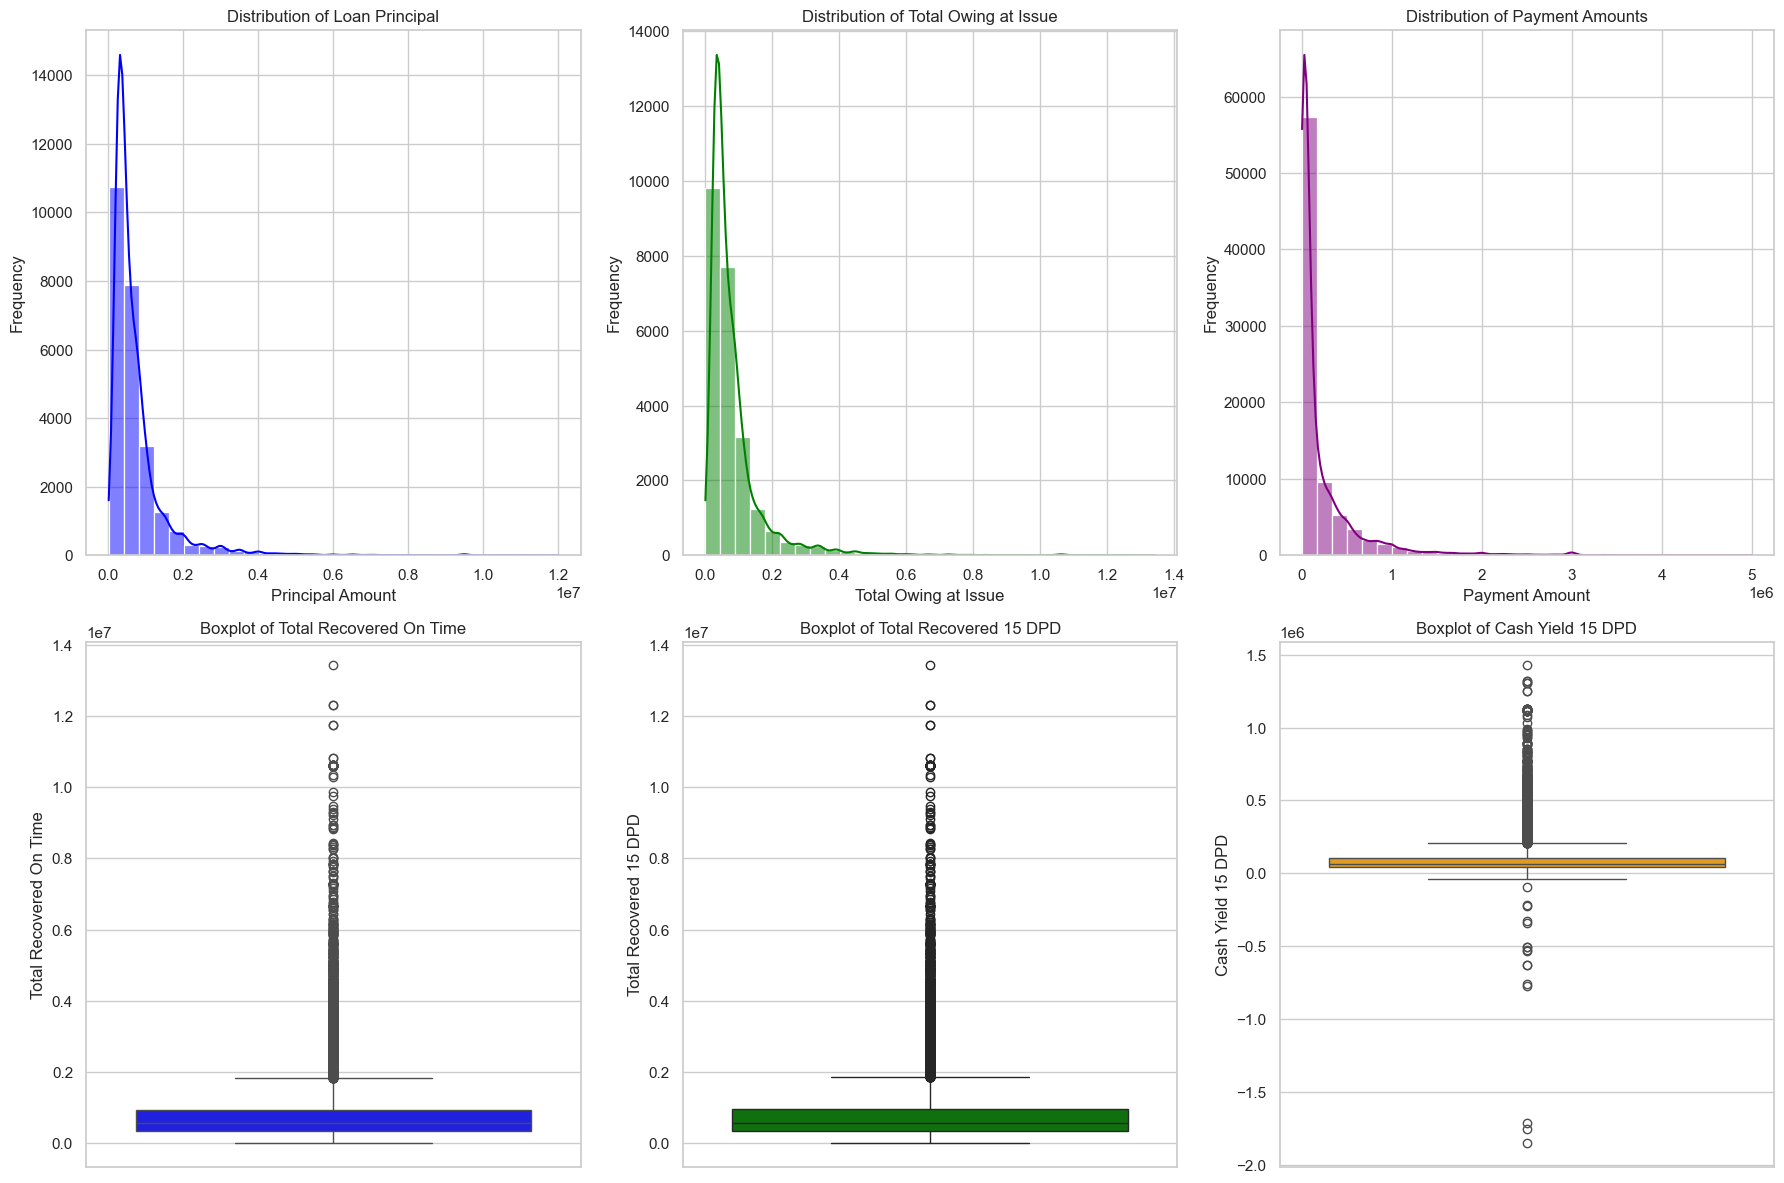

In [34]:
# Set plot style
sns.set(style='whitegrid')

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Principal Distribution
sns.histplot(loan_train['principal'], kde=True, bins=30, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Loan Principal')
axes[0, 0].set_xlabel('Principal Amount')
axes[0, 0].set_ylabel('Frequency')

# total_owing_at_issue distribution
sns.histplot(loan_train['total_owing_at_issue'], kde=True, bins=30, color='green', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Total Owing at Issue')
axes[0, 1].set_xlabel('Total Owing at Issue')
axes[0, 1].set_ylabel('Frequency')

# Value of payment distribution
sns.histplot(payment_train['amount'], kde=True, bins=30, color='purple', ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Payment Amounts')
axes[0, 2].set_xlabel('Payment Amount')
axes[0, 2].set_ylabel('Frequency')

# Total_recovered_on_time distribution
sns.boxplot(y=loan_train['total_recovered_on_time'], color='blue', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Total Recovered On Time')
axes[1, 0].set_ylabel('Total Recovered On Time')

# Total recovered Recovered 15 DPD
sns.boxplot(y=loan_train['total_recovered_15_dpd'], color='green', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of Total Recovered 15 DPD')
axes[1, 1].set_ylabel('Total Recovered 15 DPD')

# Cash Yield 15 DPD
sns.boxplot(y=loan_train['cash_yield_15_dpd'], color='orange', ax=axes[1, 2])
axes[1, 2].set_title('Boxplot of Cash Yield 15 DPD')
axes[1, 2].set_ylabel('Cash Yield 15 DPD')

plt.tight_layout()
plt.show()


*Right-Skewed Distributions*

`loan principal, owing amounts, and payment amounts` are skewed, meaning most loans and payments are smaller, with only a few large values.

*Presence of Outlier*

Especially in the `amount recovered on time, the total recovered 15 days past due, and the cash yield` columns, outliers are seen. 

Distribution of `approval_status`.

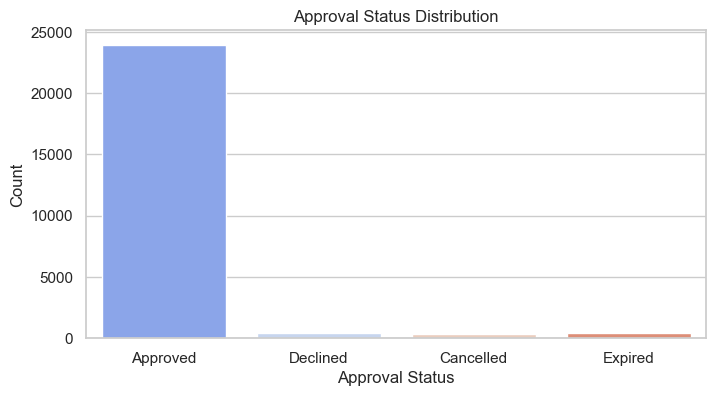

In [35]:
# Approval status distribution in loan_train
plt.figure(figsize=(8, 4))
sns.countplot(x='approval_status', data=loan_train, palette='coolwarm')
plt.title('Approval Status Distribution')
plt.xlabel('Approval Status')
plt.ylabel('Count')
plt.show()

* Distribution of `paid_late`.

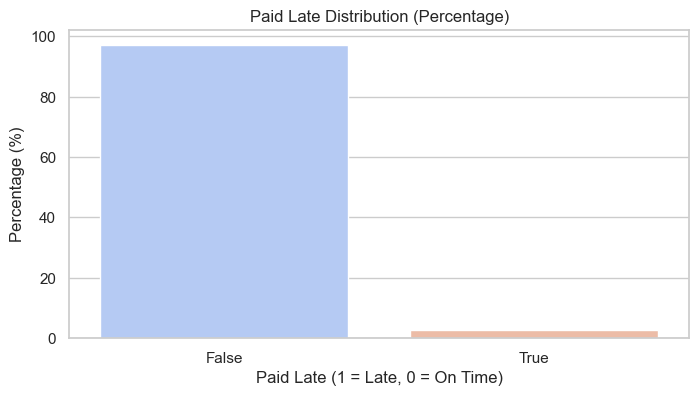

Paid Late Percentage Distribution:
paid_late
False    97.231296
True      2.768704
Name: proportion, dtype: float64


In [36]:
# Calculate percentage distribution
paid_late_percent = loan_train['paid_late'].value_counts(normalize=True) * 100
# Plot the percentage distribution of paid_late
plt.figure(figsize=(8, 4))
sns.barplot(x=paid_late_percent.index, y=paid_late_percent.values, palette='coolwarm')
plt.title('Paid Late Distribution (Percentage)')
plt.xlabel('Paid Late (1 = Late, 0 = On Time)')
plt.ylabel('Percentage (%)')
plt.show()

print("Paid Late Percentage Distribution:")
print(paid_late_percent)


A very large majority of loans (about 97.2%) are paid on time (False), while only 2.8% of loans are paid late (True).

Next, for Bivariate Analysis, we will clean the `loan_train` and `payment_train`.

#### Step 3. Data Cleaning and Preprocessing

Step 3.1: First, let's aggregate the payment information and extract relevant information.

In [37]:
def aggregate_payment_info(payment_data: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates the payment data by loan_id to avoid duplicates and create summary statistics,
    including transaction type. Handles missing transaction_type values by replacing them with 'Unknown'.
    
    Args:
    payment_data (pd.DataFrame): The payment dataset to be aggregated.
    
    Returns:
    pd.DataFrame: Aggregated payment data containing summary statistics for each loan.
    
    The following summary statistics are calculated:
    1. Total Paid: Sum of all payment amounts.
    2. Number of Payments: Total number of payments for each loan.
    3. Earliest Payment: The earliest payment date.
    4. Latest Payment: The most recent payment date.
    """
        # Fill missing transaction_type with 'Unknown'
    payment_data['transaction_type'] = payment_data['transaction_type'].fillna('Unknown')
    print('Payment data shape before dropping duplicates:', payment_data.shape)
    payment_data = payment_data.drop_duplicates()
    print('Payment data shape after dropping duplicates:', payment_data.shape)
    
    # Group by loan_id and aggregate the payment data
    payment_aggregated = payment_data.groupby(['loan_id','transaction_type']).agg(
        total_paid=('amount', 'sum'),  # Total amount paid for the loan
        num_payments=('amount', 'count'),  # Number of payments
        earliest_payment=('paid_at', 'min'),  # Earliest payment date
        latest_payment=('paid_at', 'max'),  # Latest payment date
    ).reset_index()
    return payment_aggregated

aggregated_payment_data = aggregate_payment_info(payment_train)


Payment data shape before dropping duplicates: (83275, 4)
Payment data shape after dropping duplicates: (83240, 4)


*Data Cleaning Helper Function*.
* Assumption for imputing `total_owing_at_issue, total_recovered_on_time, total_recovered_15_dpd, cash_yield_15_dpd` with `0` is that These variables reflect the financial performance of the loan, with missing values indicating cases where no data is available yet, likely for ongoing loans or loans that haven't reached maturity.
* `Transaction Type` reflect details about specific payments. It is likely that not all transactions are labeled with a type.


In [38]:
def clean_and_merge_data(loan_data: pd.DataFrame, payment_data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the loan and payment datasets by handling missing values and duplicates,
    aggregates the payment data.
    
    Args:
    loan_data : The loan dataset that needs to be cleaned.
    payment_data : The aggregated payment dataset that needs to be merged.
    
    Returns:
    pd.DataFrame: Merged dataset containing only loans with corresponding payments.
    
    Missing Data Handling:
    1. Dismissal Description: Dropped as it is not relevant for approved loans.
    2. Credit Officer ID: Imputed with mode (most frequent officer).
    3. Total Owing at Issue, Total Recovered, Cash Yield: Imputed with 0 as no recoveries have been made yet.
    4. Loan Number: Imputed with 'applying_for_loan_number' where 'loan_number' is missing.
    """
    
    # ------ Handle missing values in loan_data ---------
    loan_data = loan_data.copy()  
    
    if 'dismissal_description' in loan_data.columns:
        loan_data.drop(columns=['dismissal_description'], inplace=True)
    
    if 'credit_officer_id' in loan_data.columns:
        loan_data['credit_officer_id'].fillna(loan_data['credit_officer_id'].mode()[0], inplace=True)
    
    financial_columns = ['total_owing_at_issue', 'total_recovered_on_time', 'total_recovered_15_dpd', 'cash_yield_15_dpd']
    loan_data[financial_columns] = loan_data[financial_columns].fillna(0)

    if 'loan_number' in loan_data.columns and 'applying_for_loan_number' in loan_data.columns:
        loan_data['loan_number'].fillna(loan_data['applying_for_loan_number'], inplace=True)
    
    # ---------- Handle missing values in aggregated payment_data --------
    payment_data = payment_data.copy()  
    
    if 'employee_count' in loan_data.columns:
        loan_data['employee_count'].fillna(loan_data['employee_count'].median(), inplace=True)
    print('Loan data shape before dropping duplicates:', loan_data.shape)
    loan_data_cleaned = loan_data.drop_duplicates()
    print('Loan data shape after dropping duplicates:', loan_data_cleaned.shape)
    merged_data = pd.merge(loan_data_cleaned, payment_data, on='loan_id', how='inner')
    
    return merged_data

merged_data = clean_and_merge_data(loan_train, aggregated_payment_data)

Loan data shape before dropping duplicates: (25102, 16)
Loan data shape after dropping duplicates: (23379, 16)


In [39]:
print('The shape of the merged data is:',merged_data.shape)

The shape of the merged data is: (24123, 21)


In [40]:
# Checking for missingness
merged_data.isnull().sum()

loan_id                     0
business_id                 0
credit_officer_id           0
acquisition_channel         0
sector                      0
principal                   0
total_owing_at_issue        0
application_number          0
applying_for_loan_number    0
loan_number                 0
employee_count              0
approval_status             0
paid_late                   0
total_recovered_on_time     0
total_recovered_15_dpd      0
cash_yield_15_dpd           0
transaction_type            0
total_paid                  0
num_payments                0
earliest_payment            0
latest_payment              0
dtype: int64

#### Step 3.2:
*Target Variable*
- **Target = 1** (Good Performance): If the customer repaid on time or within 15 days.
- **Target = 0** (Bad Performance): If the customer repaid more than 15 days late or the loan was written off.

*Numida Business Assumptions informing the target variable*

1. On-time Repayment Drives Retention
   - **Assumption**: Customers who repay on time or within 15 days are more likely to borrow again.On time epayment indicates low risk and helps build long term relationships witht the clients.

2. Late Payments Signal High Risk
   - **Assumption**: Loans repaid more than 15 days late indicate higher risk and lower chances of relending. Late repayments suggest financial instability, increasing the likelihood of default.

3. Negative Yield or Write-offs Indicate Bad Performance
   - **Assumption**: Loans with negative yield or that are written off are classified as bad performance.And the implication is that financial losses directly hurt profitability, so these loans are to be avoided.

4. 15-day Grace Period for Flexibility
   - **Assumption**: Repayment within 15 days is considered good performance. That is,flexibility improves customer satisfaction without significant risk.

 5. Historical Repayment Patterns Predict Future Behavior
   - **Assumption**: Past repayment behavior (on time or late) is a strong predictor of future performance.That is, Reliable historical patterns guide better lending decisions.


In [44]:
def define_target_variable(data: pd.DataFrame) -> pd.DataFrame:
    """
    Defines the target variable for loan performance based on Numida's criteria.
    
    Args:
    data (pd.DataFrame): The merged dataset containing loan and payment information.
    
    Returns:
     pd.DataFrame: The dataset with target column where:
                  - 1 = Loan repaid on time (or within 15 days)
                  - 0 = Loan repaid more than 15 days late or written off
    """
    
    data['target'] = 1  # Default: good performance(on time)
    data.loc[data['paid_late'] == True, 'target'] = 0 # Mark loans as bad performance if paid_late is True 
    data.loc[data['cash_yield_15_dpd'] < 0, 'target'] = 0 # Mark loans as bad performance if cash_yield_15_dpd indicates a  loss 
    return data
merged_data = define_target_variable(merged_data)


Next, lets have a look at the distribution of the data.

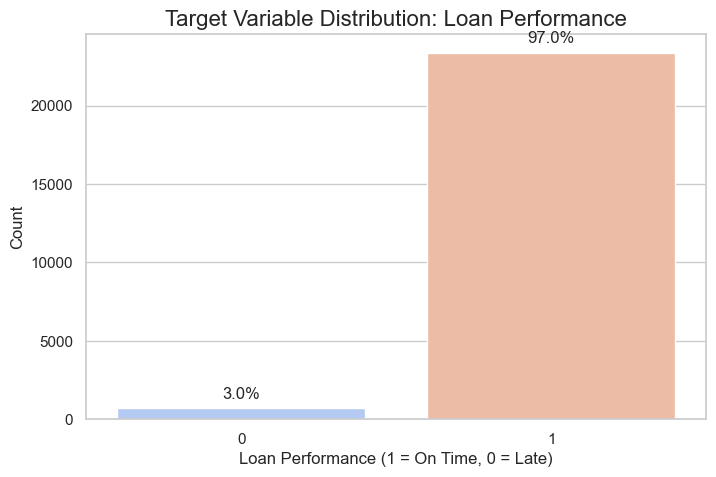

In [42]:
# Plot with percentages
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='target', data=merged_data, palette='coolwarm')

# Calculate percentages
total = len(merged_data['target'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add labels and title
plt.title('Target Variable Distribution: Loan Performance', fontsize=16)
plt.xlabel('Loan Performance (1 = On Time, 0 = Late)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show plot
plt.show()


**Note*:* Class Imbalance in Target Variable

In the target variable there is a  class imbalance, where the majority of loans are either repaid on time or within 15 days. In future work(to polish up this work), it will be crucial to address this imbalance to ensure the model is not biased toward the dominant class.

Potential Solutions:
- Oversampling the minority class (loans repaid late).
- Undersampling the majority class (on-time loans).
- Using advanced techniques like Synthetic Minority Over-sampling Technique.
- Applying class weights in machine learning models to balance the impact of each class.


In [43]:
# merged_data.to_csv('Merged_payment_loan_train_data.csv',index=False)

#### Step 5: Modelling

##### Modelling strategy: XGBoost
*Why XGBoost for Loan Default Prediction?*

XGBoost excels in financial prediction tasks due to its ability to handle complex, non-linear relationships and large datasets. According to Yun-tao, Zheng (2022), XGBoost and LightGBM perform exceptionally well in loan default prediction, particularly with imbalanced data, handling missing values and dealing with non-linear relationships; in this particular case, a loan repayment prediction problem, the relationship between features (e.g, loan amount, sector, repayment history) and the target (late vs. on-time repayment) is unlikely to be purely linear.


The study, *A Default Prediction Method using XGBoost and LightGBM*, highlights XGBoost's efficiency and scalability, making it an ideal choice for predicting loan repayment performance in Numida's dataset.

**Reference**:  
Yun-tao, Zheng. (2022). *A Default Prediction Method using XGBoost and LightGBM*. 210-213. [doi: 10.1109/ICICML57342.2022.10009823](https://doi.org/10.1109/ICICML57342.2022.10009823)



In [45]:
train_data = merged_data.copy()
test_data = test_loan.copy()

The cross-validation scores look quite high, which might suggest potential overfitting.

In [46]:
def load_data(train_path, test_path):
    """
    Load training and testing datasets from provided file paths.
    """
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    return train_data, test_data

def drop_columns(data, columns_to_drop):
    """
    Drop unnecessary columns from the dataset.
    """
    return data.drop(columns=columns_to_drop, errors='ignore')

def handle_missing_values(data):
    """
    Fill missing values with median for numerical columns and mode for categorical columns.
    """
    # Fill missing numerical values with the median
    for column in data.select_dtypes(include=['float64', 'int64']).columns:
        data[column].fillna(data[column].median(), inplace=True)
    
    # Fill missing categorical values with the mode
    for column in data.select_dtypes(include=['object']).columns:
        data[column].fillna(data[column].mode()[0], inplace=True)
    
    return data

def prepare_data(train_data, test_data, target_column):
    """
    Prepare training and testing datasets by dropping unnecessary columns and handling missing values.
    """
    columns_to_drop_train = ["loan_id", "business_id", "credit_officer_id", "earliest_payment", "latest_payment", "dismissal_description", "total_paid", "num_payments"]
    columns_to_drop_test = ["loan_id", "business_id", "credit_officer_id", "dismissal_description", "payment_status"]
    
    # Drop unnecessary columns
    train_data = drop_columns(train_data, columns_to_drop_train)
    test_data = drop_columns(test_data, columns_to_drop_test)
    
    # Handle missing values
    train_data = handle_missing_values(train_data)
    test_data = handle_missing_values(test_data)
    
    # Separate features and target variable
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    
    return X_train, y_train, test_data

def create_preprocessor(X_train):
    """
    Create a preprocessing pipeline for numerical and categorical features.
    """
    categorical_features = X_train.select_dtypes(include=['object']).columns
    numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    
    # Preprocessing for numerical and categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )
    return preprocessor

def evaluate_model(model_pipeline, X_train, y_train):
    """
    Evaluate the model using cross-validation with accuracy, precision, recall, and F1-score.
    """
    scoring_metrics = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted')
    }
    
    # Perform cross-validation for each metric
    for metric_name, scorer in scoring_metrics.items():
        scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring=scorer)
        print(f"Cross-validation {metric_name.capitalize()} Scores: {scores}")
        print(f"Mean Cross-validation {metric_name.capitalize()}: {scores.mean():.2f}\n")

def align_test_data(test_data, X_train):
    """
    Align the test dataset columns with the training dataset columns.
    """
    for column in X_train.columns:
        if column not in test_data.columns:
            # Fill missing columns in test data with median or mode from training data
            if X_train[column].dtype in ['float64', 'int64']:
                test_data[column] = X_train[column].median()
            else:
                test_data[column] = X_train[column].mode()[0]
    
    return test_data[X_train.columns]

In [48]:
# Load training and testing data
train_data, test_data = load_data(os.path.join('..', 'data', 'processed', 'Merged_payment_loan_train_data.csv'),os.path.join('..', 'data', 'raw', 'test_loan_data.csv'))# "Merged_payment_loan_train_data.csv", "test_loan_data.csv")

# Prepare the data
X_train, y_train, test_data_cleaned = prepare_data(train_data, test_data, target_column='target')

# Create the preprocessing pipeline
preprocessor = create_preprocessor(X_train)

# Create the model pipeline with XGBoost, increasing regularization parameters
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=50, max_depth=3, reg_lambda=10.0, reg_alpha=5.0))
])

# Evaluate the model
evaluate_model(model_pipeline, X_train, y_train)

# Fit the model
model_pipeline.fit(X_train, y_train)

# Align the test data with training data columns
test_data_aligned = align_test_data(test_data_cleaned, X_train)

# Make predictions on the test data
test_predictions = model_pipeline.predict(test_data_aligned)

Cross-validation Accuracy Scores: [0.99523316 0.99357513 0.99170984 0.99378109 0.99564677]
Mean Cross-validation Accuracy: 0.99

Cross-validation Precision Scores: [0.99525648 0.99361743 0.99178013 0.99382072 0.99566622]
Mean Cross-validation Precision: 0.99

Cross-validation Recall Scores: [0.99523316 0.99357513 0.99170984 0.99378109 0.99564677]
Mean Cross-validation Recall: 0.99

Cross-validation F1 Scores: [0.99503672 0.99320709 0.99107472 0.99343499 0.99548297]
Mean Cross-validation F1: 0.99



The cross-validation scores continue to be extremely high, which might indicate that the model is overfitting.

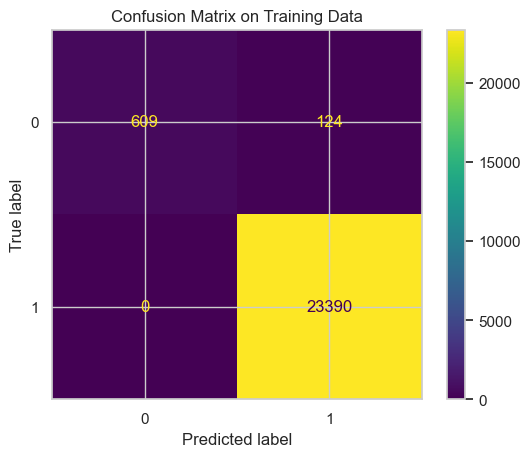

In [49]:
# Evaluate model on training data and display confusion matrix
y_train_pred = model_pipeline.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix on Training Data")
plt.show()

The confusion matrix indicates a significant class imbalance, where the majority class is heavily favored. This imbalance may be causing the model to predict mostly the majority class, leading to poor performance for the minority class.

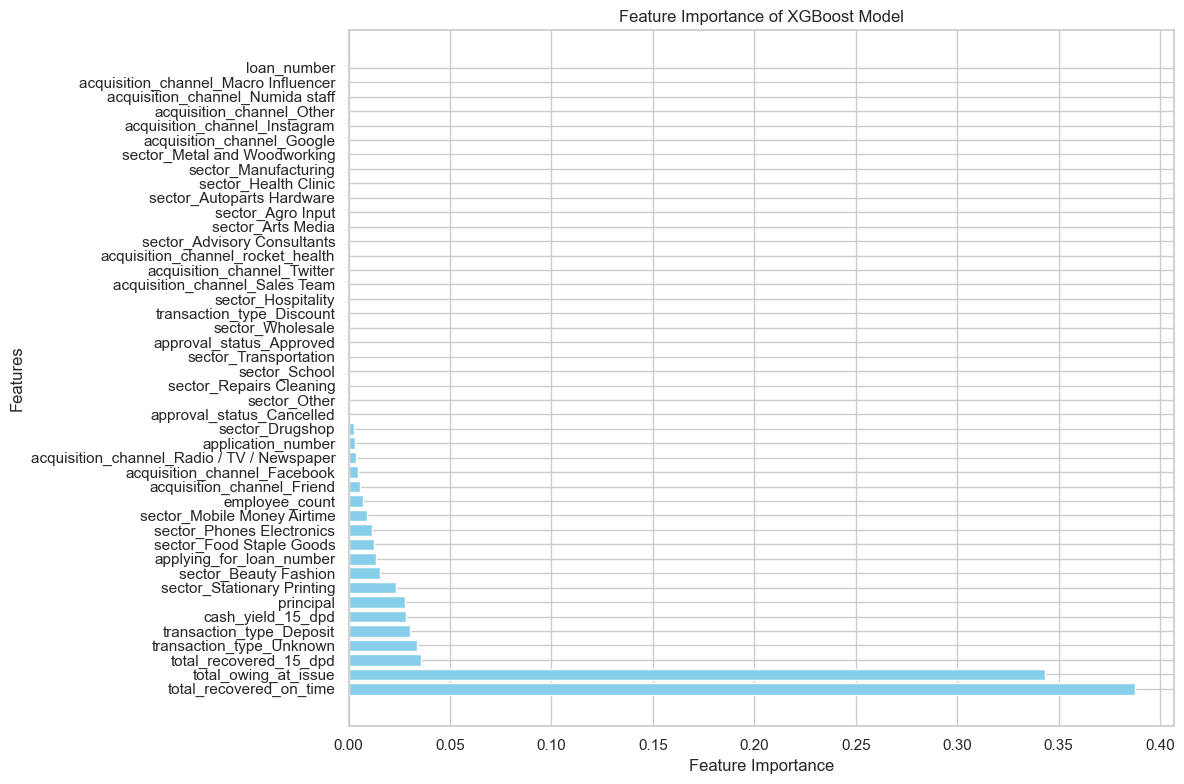

In [53]:
# Display feature importance
xgb_model = model_pipeline.named_steps['xgb']
feature_importances = xgb_model.feature_importances_
categorical_features = model_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
numerical_features = model_pipeline.named_steps['preprocessor'].transformers_[0][2]
feature_names = list(numerical_features) + list(categorical_features)

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of XGBoost Model')
plt.tight_layout()
plt.show()

##### Challenges and Recommendations for Future Work

*Challenges*

1. Class Imbalance: The dataset showed an imbalance between loans that were repaid and those that were not, potentially leading to bias in the model's predictions. The high accuracy might be driven by the majority class, leading to poor performance on the minority class.

2. Overfitting: Despite using regularization techniques, the model's cross-validation metrics were almost perfect, indicating a possible overfitting issue. This could lead to reduced generalization ability when applied to unseen data.

*Recommendations for Future Work*

1. Address Class Imbalance:

* Use techniques such as SMOTE (Synthetic Minority Over-sampling Technique) or undersampling the majority class to balance the dataset.

2. Hyperparameter Tuning:

* Use GridSearchCV or RandomizedSearchCV to optimize the model's hyperparameters, including learning rate, number of estimators, and maximum tree depth, to improve generalization.

3. Feature Engineering:

Create new features based on domain knowledge, such as features related to borrower history, interaction with Numida, or external factors like economic indicators. This can improve the predictive power of the model.

4. Feature Transformation and outlier Removal.

* Conclusion*

The `XGBoost-based model` showed promising results in predicting loan repayment behavior. However, challenges like class imbalance and overfitting need further attention. Addressing these challenges through feature engineering, class balancing, and hyperparameter tuning can further enhance model performance and make it more suitable for real-world application.